<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/Stock_NeurIPS2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train DRL Agents](#5)
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
  

<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages


In [1]:
## install finrl library
#!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git


<a id='1.2'></a>
## 2.2. A list of Python packages 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools


In [4]:
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


<a id='1.4'></a>
## 2.4. Create Folders

In [5]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [6]:
# from config.py, TRAIN_START_DATE is a string
print(f'start date: {TRAIN_START_DATE}')
# from config.py, TRAIN_END_DATE is a string
print(f'end date: {TRAIN_END_DATE}')

start date: 2014-01-06
end date: 2020-07-31


In [7]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2015-01-01'
TEST_START_DATE = "2015-01-01"
TEST_END_DATE = "2016-01-01"
TRADE_START_DATE = '2016-01-01'
TRADE_END_DATE = '2017-11-11'


In [8]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.ARK_TICKER).fetch_data() # check config tickers for lists -- DOW_30_TICKER

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ZM: Data doesn't exist for startDate = 1230753600, endDate = 1510344000
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- COIN: Data doesn't exist for startDate = 1230753600, endDate = 1510344000
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- PATH: Data doesn't exist for startDate = 1230753600, endDate = 1510344000
[*********************10

In [9]:
print(config_tickers.ARK_TICKER)

['TSLA', 'ZM', 'ROKU', 'EXAS', 'NTLA', 'SQ', 'TDOC', 'CRSP', 'COIN', 'PATH', 'BEAM', 'TWLO', 'U', 'SHOP', 'DKNG', 'UW', 'RBLX', 'DNA', 'HOOD', 'PD', 'FATE', 'TWST', 'TXG', 'NVDA', 'VCYT', 'PACB', 'SGFY', 'TSP', 'SPOT', 'NVTA', 'MTLS', 'TWOU', 'CERS', 'BLI', 'GEN']


In [10]:
df.shape

(21875, 8)

In [11]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2008-12-31,0.70,0.7000,0.640,0.700000,326200.0,CERS,2
1,2008-12-31,0.54,0.5700,0.520,0.570000,77900.0,EXAS,2
2,2008-12-31,12.97,13.6500,12.880,5.176326,7946200.0,GEN,2
3,2008-12-31,1.98,2.0675,1.945,1.852039,44158000.0,NVDA,2
4,2008-12-31,0.12,0.1200,0.120,0.120000,0.0,UW,2


In [12]:
df

,date,open,high,low,close,volume,tic,day
0,2008-12-31,0.700000,0.700000,0.640000,0.700000,326200.0,CERS,2
1,2008-12-31,0.540000,0.570000,0.520000,0.570000,77900.0,EXAS,2
2,2008-12-31,12.970000,13.650000,12.880000,5.176326,7946200.0,GEN,2
3,2008-12-31,1.980000,2.067500,1.945000,1.852039,44158000.0,NVDA,2
4,2008-12-31,0.120000,0.120000,0.120000,0.120000,0.0,UW,2
...,...,...,...,...,...,...,...,...
21870,2017-11-10,29.450001,29.600000,28.299999,29.000000,699800.0,TDOC,4
21871,2017-11-10,20.166668,20.557333,20.123333,20.199333,69381000.0,TSLA,4
21872,2017-11-10,25.840000,26.250000,25.160000,25.549999,3418400.0,TWLO,4
21873,2017-11-10,63.099998,64.059998,62.709999,63.529999,231100.0,TWOU,4


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [13]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = True)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (2233, 8)
Successfully added vix
Successfully added turbulence index
Successfully added user defined features


In [14]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [15]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,macds,...,rsi_13,rsi_21,rsi_34,rsi_55,rsi_89,cci_30,dx_30,vix,turbulence,daily_return
0,2008-12-31,CERS,0.7000,0.7000,0.640,0.700000,326200.0,2.0,0.000000,0.000000,...,100.0,100.0,100.0,100.0,100.0,66.666667,100.0,40.000000,0.0,-0.185714
1,2008-12-31,EXAS,0.5400,0.5700,0.520,0.570000,77900.0,2.0,0.000000,0.000000,...,100.0,100.0,100.0,100.0,100.0,66.666667,100.0,40.000000,0.0,-0.185714
2,2008-12-31,GEN,12.9700,13.6500,12.880,5.176326,7946200.0,2.0,0.000000,0.000000,...,100.0,100.0,100.0,100.0,100.0,66.666667,100.0,40.000000,0.0,8.081273
3,2008-12-31,NVDA,1.9800,2.0675,1.945,1.852039,44158000.0,2.0,0.000000,0.000000,...,100.0,100.0,100.0,100.0,100.0,66.666667,100.0,40.000000,0.0,-0.642210
4,2009-01-02,CERS,0.7000,0.8200,0.690,0.820000,243300.0,4.0,0.002692,0.001496,...,100.0,100.0,100.0,100.0,100.0,66.666667,100.0,39.189999,0.0,-0.557245
5,2009-01-02,EXAS,0.5700,0.5800,0.530,0.580000,81200.0,4.0,0.000224,0.000125,...,100.0,100.0,100.0,100.0,100.0,66.666667,100.0,39.189999,0.0,-0.292683
6,2009-01-02,GEN,13.5900,14.8700,13.480,5.666391,12527000.0,4.0,0.010995,0.006108,...,100.0,100.0,100.0,100.0,100.0,66.666667,100.0,39.189999,0.0,8.769641
7,2009-01-02,NVDA,2.0175,2.1925,2.010,1.998916,49712400.0,4.0,0.003295,0.001831,...,100.0,100.0,100.0,100.0,100.0,66.666667,100.0,39.189999,0.0,-0.647233
8,2009-01-05,CERS,0.8000,0.8700,0.800,0.850000,151000.0,0.0,0.004361,0.002670,...,100.0,100.0,100.0,100.0,100.0,87.012993,100.0,39.080002,0.0,-0.574770
9,2009-01-05,EXAS,0.5900,0.6500,0.590,0.650000,53200.0,0.0,0.002457,0.001080,...,100.0,100.0,100.0,100.0,100.0,100.000000,100.0,39.080002,0.0,-0.235294


<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-07-01

Trading data period: 2020-07-01 to 2021-10-31


In [16]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

6040
1876


In [17]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,macds,...,rsi_13,rsi_21,rsi_34,rsi_55,rsi_89,cci_30,dx_30,vix,turbulence,daily_return
1508,2014-12-30,NVDA,5.105,5.130000,5.085000,4.893847,11212000.0,1.0,0.032833,0.036928,...,51.411925,53.470940,54.305249,54.294491,54.171784,-3.673849,10.379188,15.920000,0.760610,-0.530582
1509,2014-12-31,CERS,6.230,6.380000,6.180000,6.240000,951400.0,2.0,0.553707,0.493413,...,66.487460,66.846707,65.210128,61.859058,57.820955,95.538053,47.188685,19.200001,2.674435,0.275070
1509,2014-12-31,EXAS,28.480,28.990000,27.379999,27.440001,903700.0,2.0,0.883273,0.928391,...,53.357637,55.297726,56.433350,56.997501,57.057175,59.217110,10.020861,19.200001,2.674435,3.397436
1509,2014-12-31,GEN,26.080,26.290001,25.610001,10.281108,2536400.0,2.0,0.078846,0.093220,...,47.383899,51.458744,53.800870,54.792408,54.658896,2.708225,5.829724,19.200001,2.674435,-0.625324
1509,2014-12-31,NVDA,5.100,5.127500,4.997500,4.816967,16630000.0,2.0,0.023239,0.034191,...,45.509730,49.785116,52.008286,52.849991,53.247857,-54.712605,2.790057,19.200001,2.674435,-0.531474


In [18]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,macds,...,rsi_13,rsi_21,rsi_34,rsi_55,rsi_89,cci_30,dx_30,vix,turbulence,daily_return
0,2016-01-04,CERS,6.190000,6.270,6.030000,6.240000,1182500.0,0.0,0.215214,0.227705,...,56.843943,58.196854,57.636392,56.163192,54.620297,56.267999,10.901308,20.700001,1.017077,-0.224835
0,2016-01-04,EXAS,8.980000,9.110,8.480000,9.000000,2326400.0,0.0,0.047627,-0.032850,...,47.291835,44.772234,41.132734,39.994055,41.396262,-16.827420,6.640800,20.700001,1.017077,0.442308
0,2016-01-04,GEN,20.549999,20.850,20.360001,8.577427,5265200.0,0.0,0.120751,0.088442,...,57.715484,56.437157,53.446689,50.447841,48.809844,70.333836,3.360028,20.700001,1.017077,-0.046953
0,2016-01-04,NVDA,8.072500,8.145,8.010000,7.905807,35807600.0,0.0,0.123279,0.164436,...,48.912159,54.889946,58.508240,59.784583,59.472231,-22.474714,4.275175,20.700001,1.017077,-0.078301
1,2016-01-05,CERS,6.490000,6.660,6.280000,6.400000,1778600.0,1.0,0.213722,0.224909,...,60.731882,60.584121,59.172261,57.172443,55.281579,103.715720,26.591215,19.340000,2.819179,-0.190468


In [19]:
INDICATORS

['macd',
 'macds',
 'macdh',
 'boll_ub',
 'boll',
 'boll_lb',
 'rsi_13',
 'rsi_21',
 'rsi_34',
 'rsi_55',
 'rsi_89',
 'cci_30',
 'dx_30']

In [20]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 4, State Space: 61


In [21]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 100000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)


## Environment for Training



In [22]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [23]:
agent = DRLAgent(env = env_train)

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True


### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 1: A2C


In [24]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:

  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)


{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
Logging to results/a2c


In [25]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None
if if_using_a2c:
  trained_model = trained_a2c


---------------------------------------
| time/                 |             |
|    fps                | 307         |
|    iterations         | 100         |
|    time_elapsed       | 1           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -5.85       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | 0.71        |
|    reward             | -0.21235326 |
|    std                | 1.04        |
|    value_loss         | 0.047       |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 358         |
|    iterations         | 200         |
|    time_elapsed       | 2           |
|    total_timesteps    | 1000        |
| train/                |             |
|    entropy_loss       | -5.85       |
|    explained_variance | 0           |


KeyboardInterrupt: 

### Agent 2: DDPG

In [39]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:

  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device
Logging to results/ddpg


In [40]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None
if if_using_ddpg:
  trained_model = trained_ddpg


---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 487      |
|    time_elapsed    | 12       |
|    total_timesteps | 6040     |
| train/             |          |
|    actor_loss      | -855     |
|    critic_loss     | 625      |
|    learning_rate   | 0.001    |
|    n_updates       | 4530     |
|    reward          | 0.0      |
---------------------------------
day: 1509, episode: 40
begin_total_asset: 100000.00
end_total_asset: 100000.00
total_reward: 0.00
total_cost: 0.00
total_trades: 0
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 436      |
|    time_elapsed    | 27       |
|    total_timesteps | 12080    |
| train/             |          |
|    actor_loss      | -753     |
|    critic_loss     | 598      |
|    learning_rate   | 0.001    |
|    n_updates       | 10570    |
|    reward          | 0.0      |
-------------------

### Agent 3: PPO

In [41]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
Logging to results/ppo


In [42]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000) if if_using_ppo else None
if if_using_ppo:
  trained_model = trained_ppo

------------------------------------
| time/              |             |
|    fps             | 1087        |
|    iterations      | 1           |
|    time_elapsed    | 1           |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | -0.29509366 |
------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1012         |
|    iterations           | 2            |
|    time_elapsed         | 4            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0058522853 |
|    clip_fraction        | 0.0372       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.67        |
|    explained_variance   | 0.392        |
|    learning_rate        | 0.00025      |
|    loss                 | -0.0371      |
|    n_updates            | 10           |
|    policy_gradient_l

-----------------------------------------
| time/                   |             |
|    fps                  | 965         |
|    iterations           | 11          |
|    time_elapsed         | 23          |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.005091614 |
|    clip_fraction        | 0.0386      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.77       |
|    explained_variance   | 0.0839      |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0816      |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00475    |
|    reward               | 0.14687666  |
|    std                  | 1.02        |
|    value_loss           | 0.341       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 964         |
|    iterations           | 12    

-----------------------------------------
| time/                   |             |
|    fps                  | 958         |
|    iterations           | 21          |
|    time_elapsed         | 44          |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.007419474 |
|    clip_fraction        | 0.0618      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.91       |
|    explained_variance   | 0.052       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0812      |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.00462    |
|    reward               | -0.21701106 |
|    std                  | 1.06        |
|    value_loss           | 0.275       |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 958          |
|    iterations           | 22 

### Agent 4: TD3

In [43]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device
Logging to results/td3


In [44]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000) if if_using_td3 else None
if if_using_td3:
  trained_model = trained_td3

-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 496        |
|    time_elapsed    | 12         |
|    total_timesteps | 6040       |
| train/             |            |
|    actor_loss      | 177        |
|    critic_loss     | 450        |
|    learning_rate   | 0.001      |
|    n_updates       | 4530       |
|    reward          | -2.0655153 |
-----------------------------------
day: 1509, episode: 110
begin_total_asset: 100000.00
end_total_asset: 681484.03
total_reward: 581484.03
total_cost: 99.90
total_trades: 4527
Sharpe: 1.033
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 443        |
|    time_elapsed    | 27         |
|    total_timesteps | 12080      |
| train/             |            |
|    actor_loss      | 228        |
|    critic_loss     | 110        |
|    learning_rate   | 0.001      |
|    n_updates   

### Agent 5: SAC

In [45]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device
Logging to results/sac


In [46]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=40000) if if_using_sac else None
if if_using_sac:
  trained_model = trained_sac

-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 226        |
|    time_elapsed    | 26         |
|    total_timesteps | 6040       |
| train/             |            |
|    actor_loss      | 451        |
|    critic_loss     | 95.8       |
|    ent_coef        | 0.18       |
|    ent_coef_loss   | 141        |
|    learning_rate   | 0.0001     |
|    n_updates       | 5939       |
|    reward          | -1.4687496 |
-----------------------------------
day: 1509, episode: 130
begin_total_asset: 100000.00
end_total_asset: 522619.83
total_reward: 422619.83
total_cost: 99.90
total_trades: 4527
Sharpe: 1.003
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 225        |
|    time_elapsed    | 53         |
|    total_timesteps | 12080      |
| train/             |            |
|    actor_loss      | 928        |
|    critic_loss 

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [47]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [48]:
insample_risk_indicator.vix.describe()

count    1510.000000
mean       20.742775
std         8.341472
min        10.320000
25%        14.730000
50%        17.990000
75%        24.265000
max        56.650002
Name: vix, dtype: float64

In [49]:
insample_risk_indicator.vix.quantile(0.996)

49.6674003601074

In [50]:
insample_risk_indicator.turbulence.describe()

count    1510.000000
mean        3.346843
std         8.370429
min         0.000000
25%         0.506804
50%         1.614804
75%         3.714998
max       224.974405
Name: turbulence, dtype: float64

In [51]:
insample_risk_indicator.turbulence.quantile(0.996)

49.478083583121744

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [52]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [53]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,macds,...,rsi_13,rsi_21,rsi_34,rsi_55,rsi_89,cci_30,dx_30,vix,turbulence,daily_return
0,2016-01-04,CERS,6.190000,6.270,6.030000,6.240000,1182500.0,0.0,0.215214,0.227705,...,56.843943,58.196854,57.636392,56.163192,54.620297,56.267999,10.901308,20.700001,1.01708,-0.224835
0,2016-01-04,EXAS,8.980000,9.110,8.480000,9.000000,2326400.0,0.0,0.047627,-0.032850,...,47.291835,44.772234,41.132734,39.994055,41.396262,-16.827420,6.640800,20.700001,1.01708,0.442308
0,2016-01-04,GEN,20.549999,20.850,20.360001,8.577429,5265200.0,0.0,0.120752,0.088442,...,57.715595,56.437223,53.446725,50.447861,48.809856,70.333945,3.360028,20.700001,1.01708,-0.046952
0,2016-01-04,NVDA,8.072500,8.145,8.010000,7.905804,35807600.0,0.0,0.123278,0.164436,...,48.912074,54.889907,58.508221,59.784568,59.472217,-22.475018,4.275175,20.700001,1.01708,-0.078301
1,2016-01-05,CERS,6.490000,6.660,6.280000,6.400000,1778600.0,1.0,0.213722,0.224909,...,60.731882,60.584121,59.172261,57.172443,55.281579,103.715720,26.591215,19.340000,2.81921,-0.190468


In [54]:
trained_model

In [55]:
trained_model = trained_sac

df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_model, 
    environment = e_trade_gym)

hit end!


In [56]:
model=trained_model, 
environment = e_trade_gym

In [57]:
df_account_value.shape

(469, 2)

In [58]:
df_account_value.tail()

,date,account_value
464,2017-11-03,375794.295513
465,2017-11-06,380831.826064
466,2017-11-07,391221.406409
467,2017-11-08,392140.105469
468,2017-11-09,385003.472874


In [59]:
df_actions.head()

,CERS,EXAS,GEN,NVDA
date,,,,
2016-01-04,100,100,100,0
2016-01-05,100,100,100,0
2016-01-06,100,100,100,0
2016-01-07,100,100,100,0
2016-01-08,100,100,100,0


<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [70]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.027160
Cumulative returns     0.051026
Annual volatility      0.492467
Sharpe ratio           0.300087
Calmar ratio           0.042985
Stability              0.005931
Max drawdown          -0.631840
Omega ratio            1.050033
Sortino ratio          0.433253
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.024087
Daily value at risk   -0.061459
dtype: float64


In [71]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (467, 8)
Annual return          0.051315
Cumulative returns     0.097173
Annual volatility      0.164102
Sharpe ratio           0.387660
Calmar ratio           0.233881
Stability              0.061791
Max drawdown          -0.219408
Omega ratio            1.067832
Sortino ratio          0.542255
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.985824
Daily value at risk   -0.020422
dtype: float64


In [72]:
df_account_value.loc[0,'date']

'2021-01-04'

In [73]:
df_account_value.loc[len(df_account_value)-1,'date']

'2022-11-09'

<a id='6.2'></a>
## 7.2 BackTestPlot

In [74]:
df_account_value.loc[0,'date']

'2021-01-04'

In [75]:
df_account_value.loc[len(df_account_value)-1,'date']

'2022-11-09'

In [76]:
df_account_value

,date,account_value
0,2021-01-04,100000.000000
1,2021-01-05,100294.913883
2,2021-01-06,98691.865140
3,2021-01-07,100919.968345
4,2021-01-08,100605.316154
...,...,...
463,2022-11-03,102010.168498
464,2022-11-04,107165.511417
465,2022-11-07,107826.540218
466,2022-11-08,109798.152080


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (467, 8)


Start date,2021-01-04
End date,2022-11-09
Total months,22
,Backtest
Annual return,2.716%
Cumulative returns,5.103%
Annual volatility,49.247%
Sharpe ratio,0.30
Calmar ratio,0.04
Stability,0.01
Max drawdown,-63.184%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,63.18,2021-11-29,2022-10-14,NaT,NaN
1,21.87,2021-02-16,2021-03-08,2021-04-13,41
2,13.10,2021-09-03,2021-10-04,2021-10-25,37
3,11.80,2021-04-15,2021-05-13,2021-05-24,28
4,11.62,2021-07-06,2021-07-16,2021-08-23,35


Stress Events,mean,min,max
New Normal,0.06%,-8.86%,10.97%


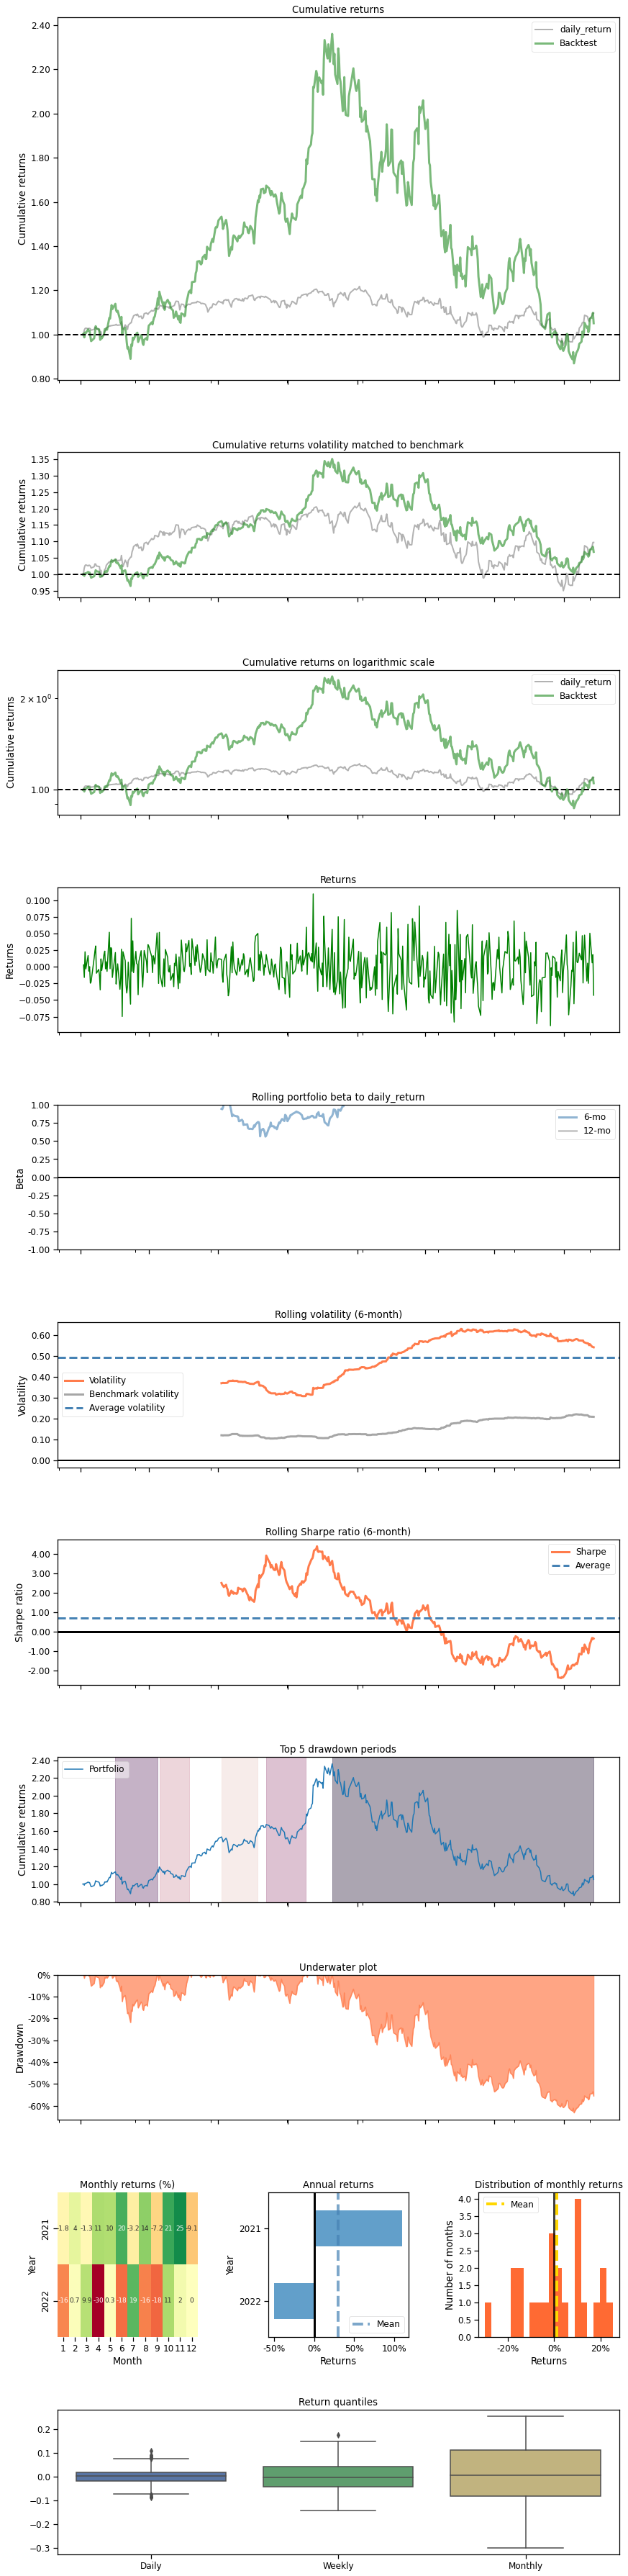

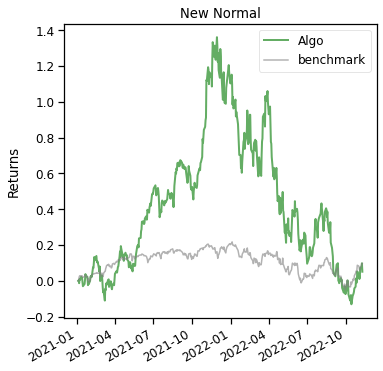

In [77]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])